# Calcul numérique du modèle MFG

Ce notebook contient le calcul des solutions numériques au modèle de trafic comme MFG proposé par Chevalier, Le Ny et Malhamé. Le schéma de discrétisation est celui proposé dans le même article, dans le but de réproduire les résultats montrés dans la dernière partie de l'article.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Calcul des itérations en arrière de HJB
Deux fonctions sont créées. _rhoTilde_ est le calcul de 
$$\tilde{\rho}_j^i = \sum_{k \geq i} \rho_j^k w((k-i)\Delta x) \Delta x$$
pour un instant j donné, qui constitue une approximation $$\int_{i\Delta x}^{\infty} \rho_{j\Delta t}(y-i\Delta x) w(y)dy$$ 

In [2]:
def rhoTilde(rho,n,w,dx):
    
    # Calcule rhoTilde

    rho_tilde = [[sum([rho[j][k]*w((k-i)*dx)*dx for k in range(i,m)]) for i in range(m)] for j in range(n)]
    return rho_tilde

La fonction _backwardsHJB_ calcule une itération du schéma en arrière pour l'équation HJB. On prend $V_T(x) = 0$ sur $[0,L]$ et on calcule $V$ et $v$ en arrière  

In [3]:
def backwardsHJB(T,L,n,m,rho,alpha,w):
    # Cette fonction calcule une itération du schéma HJB.
    dt = T/n
    dx = L/m
    V = [[0 for i in range(m)] for j in range(n)]
    v = [[0 for i in range(m)] for j in range(n)]
    rho_tilde = rhoTilde(rho,n,w,dx)
    liste_temps = reversed(list(range(n-1)))
    for j in liste_temps:
        for i in range(m-1):
            v[j][i] = 1/alpha * (1 - rho_tilde[j][i] + (V[j][i+1] - V[j][i])/dx)
            V[j][i] = V[j+1][i] + dt/2 * alpha * (v[j][i])**2
    return V,v


## Calcul de l'itération en volumes finis pour la loi de conservation
On utilise le schéma Lax-Wendroff explicite pour calculer $\rho$ à partir du $v$ obtenu par HJB.

In [13]:
def discretisationLW(rho,v,dt,dx,n,m):

    # Calcule une itération du calcul de rho utilisant le schéma Lax-Wendroff

    rhov = [[rho[j][i]*v[j][i] for i in range(m)] for j in range(n)]
    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = rho[j][i] -\
            dt/(2*dx) * (rhov[j][i+1] - rhov[j][i-1]) +\
            1/2 * (dt/dx)**2 * ((v[j][i] + v[j][i+1])/2 * (rhov[j][i+1]-rhov[j][i]) -\
                                (v[j][i-1] + v[j][i])/2 * (rhov[j][i] - rhov[j][i-1]))
    return rho

## Application aux conditions proposées dans l'article

Text(0.5, 1.0, "Condition d'entrée")

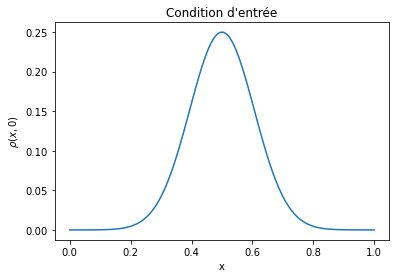

In [5]:
L = 1
T = 1
n = 100
m = 100
x  = np.linspace(0,L,m)
rho_0 = 0.25*np.exp(-((x-0.5)/0.15)**2)
alpha = 1/0.07

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

### Fonction d'anticipation impulsionnelle

In [6]:
# Discrétisation d'une delta de Dirac : w(x) = 1/dx si x = 0, 0 sinon
w = lambda y: m/L * (y == 0)

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
for h in range(40):
    V,v1 = backwardsHJB(T,L,n,m,rho,alpha,w)
    res = T*L/(m*n) * np.sqrt(sum([sum([(v[j][i]-v1[j][i])**2 for i in range(m)]) for j in range(n)]))
    v = v1
    rho1 = discretisationLW(rho,v,T/n,L/m,n,m)
    eps2 = T*L/(m*n) * np.sqrt(sum([sum([(rho1[j][i]-rho[j][i])**2 for i in range(m)]) for j in range(n)]))
    liste_eps2.append(eps2)
    rho = rho1
    it += 1
    
rho_impulsion = rho
v_impulsion = v

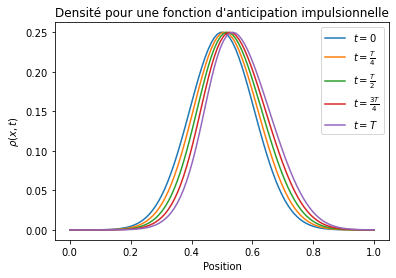

In [7]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.title("Densité pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\rho(x,t)$")
plt.legend()

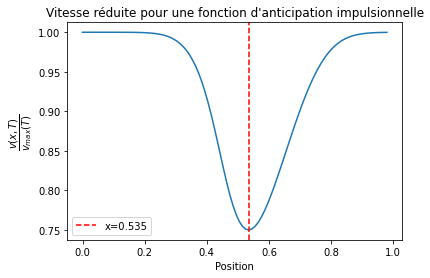

In [8]:
plt.figure()
plt.plot(x[:m-2],v[n-2][:m-2]/max(v[n-2][:m-2]))
i_xmin = v[n-2][:m-2].index(min(v[n-2][:m-2]))
plt.axvline(x[:m-2][i_xmin],color='r',linestyle='--',label='x={:.3}'.format(x[:m-2][i_xmin]))
plt.title("Vitesse réduite pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$\dfrac{v(x,T)}{v_{max}(T)}$")
plt.legend()

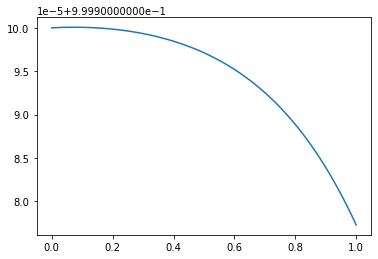

In [9]:
masse_0 = sum(rho_0)*L/m
masse_imp = [sum(rhot)/masse_0*L/m for rhot in rho_impulsion]
plt.plot(np.linspace(0,T,n), masse_imp)

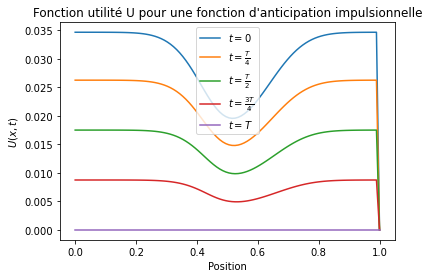

In [10]:
plt.figure()
plt.plot(x,V[0],label=r"$t=0$")
plt.plot(x,V[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,V[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,V[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,V[n-1],label="$t=T$")
plt.title("Fonction utilité U pour une fonction d'anticipation impulsionnelle")
plt.xlabel("Position")
plt.ylabel(r"$U(x,t)$")
plt.legend()

### Fonction d'anticipation exponentielle

In [11]:
EX0 = sum([x[i] * rho_0[i]*L/m for i in range(len(x))])
VarX0 = sum([(x[i]-EX0)**2 * rho_0[i] * L/m for i in range(len(x))])
lda = 0.1 * np.sqrt(VarX0)
w = lambda y: 1/lda * np.exp(-y/lda)

In [12]:
rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
for h in range(20):
    V,v1 = backwardsHJB(T,L,n,m,rho,alpha,w)
    res = T*L/(m*n) * np.sqrt(sum([sum([(v[j][i]-v1[j][i])**2 for i in range(m)]) for j in range(n)]))
    v = v1
    rho1 = discretisationLW(rho,v,T/n,L/m,n,m)
    eps2 = T*L/(m*n) * np.sqrt(sum([sum([(rho1[j][i]-rho[j][i])**2 for i in range(m)]) for j in range(n)]))
    liste_eps2.append(eps2)
    rho = rho1
    it += 1
    
rho_exponentielle = rho
v_exponentielle = v

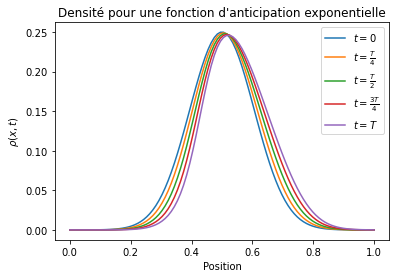

In [13]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.title("Densité pour une fonction d'anticipation exponentielle")
plt.xlabel("Position")
plt.ylabel(r"$\rho(x,t)$")
plt.legend()

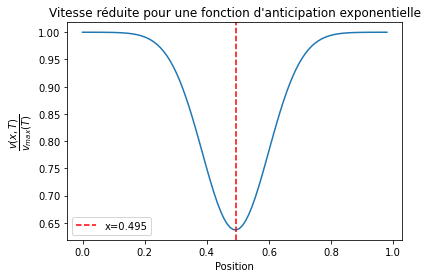

In [14]:
plt.figure()
plt.plot(x[:m-2],v[0][:m-2]/max(v[0][:m-2]))
i_xmin = v[0][:m-2].index(min(v[0][:m-2]))
plt.axvline(x[:m-2][i_xmin],color='r',linestyle='--',label='x={:.3}'.format(x[:m-2][i_xmin]))
plt.title("Vitesse réduite pour une fonction d'anticipation exponentielle")
plt.xlabel("Position")
plt.ylabel(r"$\dfrac{v(x,T)}{v_{max}(T)}$")
plt.legend()

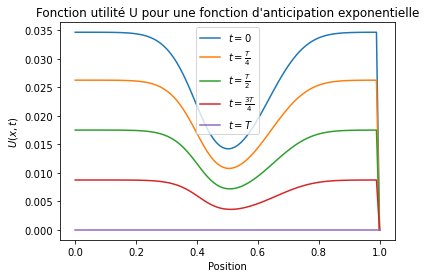

In [15]:
plt.figure()
plt.plot(x,V[0],label=r"$t=0$")
plt.plot(x,V[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,V[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,V[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,V[n-1],label="$t=T$")
plt.title("Fonction utilité U pour une fonction d'anticipation exponentielle")
plt.xlabel("Position")
plt.ylabel(r"$U(x,t)$")
plt.legend()

In [16]:
lda

0.012287009880629477

### Obtention du diagramme fondamental

-1.0000000000000002

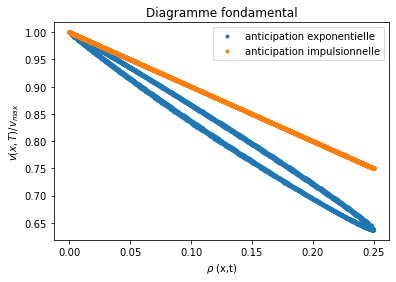

In [17]:
rho_exp_abscisse = [rho_exponentielle[j][i] for i in range(m-1) for j in range(n-1)] 
v_exp_max = max(max(v_exponentielle))
v_exp_ordonnee = [v_exponentielle[j][i]/v_exp_max for i in range(m-1) for j in range(n-1)]
rho_imp_abscisse = [rho_impulsion[j][i] for i in range(m-1) for j in range(n-1)]
v_imp_max = max(max(v_impulsion))
v_imp_ordonnee = [v_impulsion[j][i]/0.07 for i in range(m-1) for j in range(n-1)]
plt.plot(rho_exp_abscisse,v_exp_ordonnee,'.',label='anticipation exponentielle')
plt.plot(rho_imp_abscisse,v_imp_ordonnee,'.',label='anticipation impulsionnelle')
plt.plot()
plt.title("Diagramme fondamental")
plt.xlabel(r"$\rho$ (x,t)")
plt.ylabel(r"$v(x,T)/v_{max}$")
plt.legend()
(v_imp_ordonnee[len(v_imp_ordonnee)//2] - v_imp_ordonnee[0])/(rho_imp_abscisse[len(v_imp_ordonnee)//2] - rho_imp_abscisse[0])

### Condition initiale échelon

Text(0.5, 1.0, "Condition d'entrée")

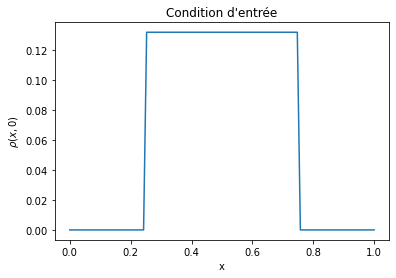

In [18]:
L = 1
T = 1
n = 100
m = 100
x  = np.linspace(0,L,m)
rho_0 = [masse_0*(xi>=0.25 and xi<=0.75)*2 for xi in x]
alpha = 1/0.07

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

### Condition initiale échelon smooth (sigmoïdes)

Text(0.5, 1.0, "Condition d'entrée")

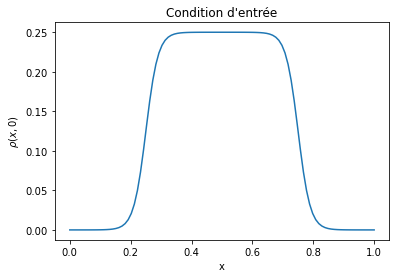

In [15]:
L = 1
T = 1
n = 100
m = 100
x  = np.linspace(0,L,m)
rho_0 = 0.25*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))
alpha = 1/0.07

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

## Rédéfinition de la discrétisation 

In [20]:
def backwardsHJB(T,L,n,m,rho,alpha,w):
    # Cette fonction calcule une itération du schéma HJB.
    dt = T/n
    dx = L/m
    V = [[0 for i in range(m)] for j in range(n)]
    v = [[0 for i in range(m)] for j in range(n)]
    liste_temps = reversed(list(range(n-1)))
    for j in liste_temps:
        for i in range(m-1):
            v[j][i] = 1/alpha * (1 - rho[j][i] + (V[j][i+1] - V[j][i])/dx)
            V[j][i] = V[j+1][i] + dt/2 * alpha * (v[j][i])**2
    return V,v

In [21]:
def discretisation_CL(rho,v,dt,dx,n,m):

    # Calcule une itération du calcul de rho utilisant le schéma Lax-Wendroff

    rhov = [[rho[j][i]*v[j][i] for i in range(m)] for j in range(n)]
    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = rho[j][i] -\
            dt/(2*dx) * (rhov[j][i+1] - rhov[j][i-1]) +\
            1/2 * (dt/dx)**2 * ((v[j][i] + v[j][i+1])/2 * (rhov[j][i+1]-rhov[j][i]) -\
                                (v[j][i-1] + v[j][i])/2 * (rhov[j][i] - rhov[j][i-1]))
    return rho

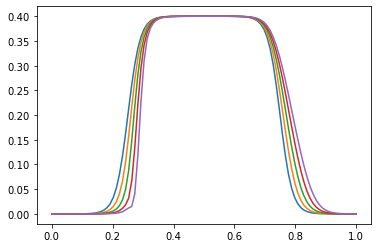

In [23]:
# Discrétisation d'une delta de Dirac : w(x) = 1/dx si x = 0, 0 sinon
w = lambda y: m/L * (y == 0)
rho_0 = 0.4*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
for h in range(30):
    V,v1 = backwardsHJB(T,L,n,m,rho,alpha,w)
    res = T*L/(m*n) * np.sqrt(sum([sum([(v[j][i]-v1[j][i])**2 for i in range(m)]) for j in range(n)]))
    v = v1
    rho1 = discretisation_CL(rho,v,T/n,L/m,n,m)
    eps2 = sum([sum([(rho1[j][i]-rho[j][i])**2 for i in range(m)]) for j in range(n)])
    liste_eps2.append(eps2)
    rho = rho1
    it += 1
    
rho_impulsion = rho
v_impulsion = v
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")

### Cas v = cte*(1-rho)

In [24]:
def discretisation_continuity(rho,k,dt,dx,n,m):

    # Calcule une itération du calcul de rho utilisant le schéma Lax-Wendroff

    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = rho[j][i] - dt/(2*dx)*k*(rho[j][i+1]*(1-rho[j][i+1]) - rho[j][i-1]*(1-rho[j][i-1])) +\
            1/2 * (dt/dx) ** 2 * (k*(1-(rho[j][i+1] + rho[j][i]))*k*(rho[j][i+1]*(1-rho[j][i+1]) - rho[j][i]*(1-rho[j][i])) -\
                                 k*(1-(rho[j][i] + rho[j][i-1]))*k*(rho[j][i]*(1-rho[j][i]) - rho[j][i-1]*(1-rho[j][i-1])))
    return rho

Il faudra calculer f pour V constante. V constante en x et v = cte*(1-rho) solution de l'équation ?

10.15868940830208


Text(0.5, 0, 'x')

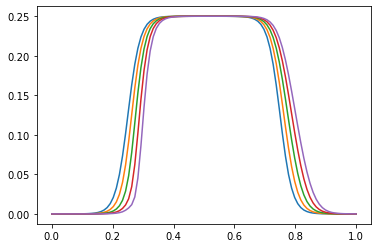

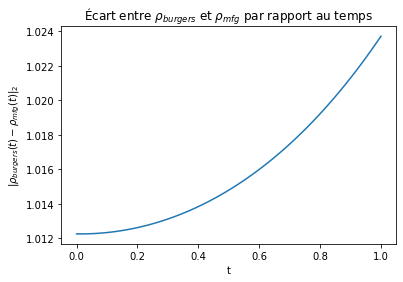

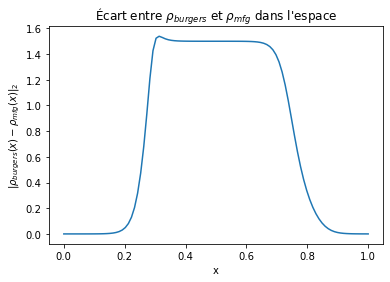

In [25]:
L = 1
T = 1
n = 100
m = 100
k = 0.07
x  = np.linspace(0,L,m)
rho_0 = 0.25*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
rho_new = discretisation_continuity(rho,k,T/n,L/m,n,m)
                                        
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")

err_norm = np.sqrt(sum([sum([(rho_new[j][i]-rho_impulsion[j][i])**2 for j in range(m)]) for i in range(n)]))
print(err_norm)

err_t = [np.sqrt(sum([(rho_new[j][i]-rho_impulsion[j][i])**2 for i in range(m)])) for j in range(n)]
plt.figure()
plt.plot(np.linspace(0,T,n),err_t)
plt.title(r"Écart entre $\rho_{burgers}$ et $\rho_{mfg}$ par rapport au temps")
plt.ylabel(r"$\| \rho_{burgers}(t) - \rho_{mfg}(t)\|_2$")
plt.xlabel("t")

err_x = [np.sqrt(sum([(rho_new[j][i]-rho_impulsion[j][i])**2 for j in range(n)])) for i in range(m)]
plt.figure()
plt.plot(np.linspace(0,L,m),err_x)
plt.title(r"Écart entre $\rho_{burgers}$ et $\rho_{mfg}$ dans l'espace")
plt.ylabel(r"$\| \rho_{burgers}(x) - \rho_{mfg}(x)\|_2$")
plt.xlabel("x")

Tracer U, comparer avec l'équation de burgers. Comprendre ce qu'on fait même avec delta. Comparaison avec le modèle classique. 

### Convergence pour lambda

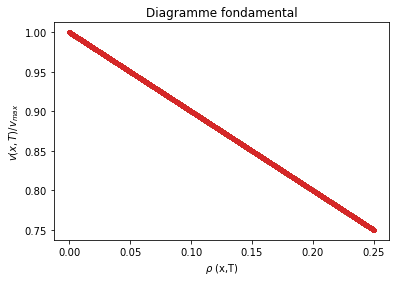

No handles with labels found to put in legend.


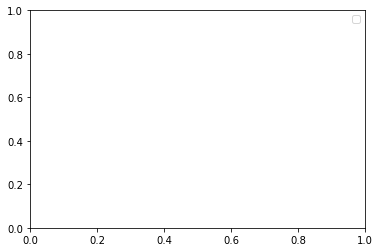

In [43]:
rho_0 = 0.25*np.exp(-((x-0.5)/0.15)**2)

plt.figure()
plt.title("Diagramme fondamental")
plt.xlabel(r"$\rho$ (x,T)")
plt.ylabel(r"$v(x,T)/v_{max}$")
for lda in [0.1,0.05,0.01,0.005]:
    w = lambda y: 1/lda * np.exp(-y/lda)
    rho = [[rho_0[j] for j in range(m)] for i in range(n)]
    v = [[0 for i in range(m)] for j in range(n)]
    for h in range(20):
        V,v = backwardsHJB(T,L,n,m,rho,alpha,w)
        rho = discretisationLW(rho,v,T/n,L/m,n,m)
    v_max = max(max(v))
    v_norm = [v[j][i]/v_max for i in range(m-1) for j in range(n-1)]
    rho_abs = [rho[j][i] for i in range(m-1) for j in range(n-1)]
    plt.plot(rho_abs,v_norm,'.',label=fr'$\lambda$ = {lda}')

### Méthode de Lax-Friedrichs, solution entropique ?

In [6]:
def discretisation_LF(rho,k,dt,dx,n,m):

    # Calcule une itération du calcul de rho utilisant le schéma Lax-Wendroff

    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = 0.5*(rho[j][i-1] + rho[j][i+1]) - dt/(2*dx) * (k*rho[j][i+1]*(1-rho[j][i+1]) - k*rho[j][i-1]*(1-rho[j][i-1]))
    return rho

In [193]:
def discretisation_upwind(rho,k,dt,dx,n,m,c):
    for j in range(n-1):
        for i in range(1,m-1):
            rho[j+1][i] = rho[j][i] - dt/(2*dx) * (rho[j][i+1]*(1-rho[j][i+1]) - rho[j][i-1]*(1-rho[j][i-1])) + 1/2* (rho[j][i+1] - 2*rho[j][i] + rho[j][i-1])      
    return rho

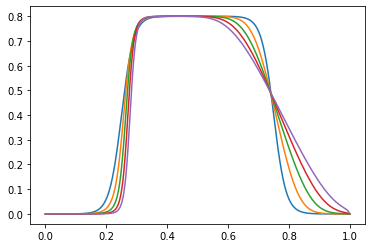

In [194]:
L = 1
T = 2
n = 2000
m = 1000
k = 0.07
x  = np.linspace(0,L,m)
rho_0 = 0.8*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))

assert max(np.abs(1-2*rho_0)) <= (L*n)/(T*m)

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
rho = discretisation_LF(rho,k,T/n,L/m,n,m)
                                        
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")

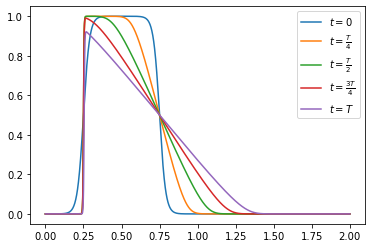

In [195]:
L = 2
T = 0.5
n = 2000
m = 2000
k = 0.07
x  = np.linspace(0,L,m)
rho_0 = 1*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))

assert  max(np.abs(1-2*rho_0)) <= (L*n)/(2*T*m)
c = (L*n)/(2*T*m)

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
rho_new = discretisation_upwind(rho,k,T/n,L/m,n,m,c)
                                        
plt.figure()
plt.plot(x,rho_new[0],label=r"$t=0$")
plt.plot(x,rho_new[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho_new[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho_new[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho_new[n-1],label="$t=T$")
plt.legend()

Faire la simulation discrete avec une distrib uniforme de N joueurs, représenter la densité discrète : c'est juste un histogramme. Vérifier le schéma d'une bonne fois pour toutes (choc et tout ça)

## Discrétisation pour f modifiée

In [23]:
def backwardsHJBCrdlg(T,L,n,m,rho,alpha,w):
    # Cette fonction calcule une itération du schéma HJB.
    dt = T/n
    dx = L/m
    V = [[0 for i in range(m)] for j in range(n)]
    v = [[0 for i in range(m)] for j in range(n)]
    rho_tilde = rhoTilde(rho,n,w,dx)
    liste_temps = reversed(list(range(n-1)))
    for j in liste_temps:
        for i in range(m-1):
            v[j][i] = (V[j+1][i+1] - V[j+1][i])/dx
            V[j][i] = V[j+1][i] + dt/2 * (v[j][i])**2 + dt*(1-rho_tilde[j][i])
    return V,v

Text(0.5, 1.0, "Condition d'entrée")

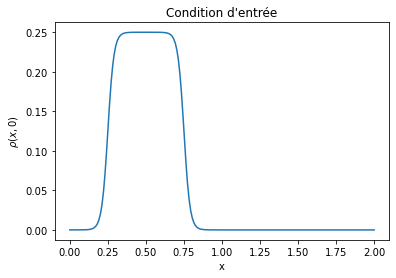

In [24]:
L = 2
T = 0.5
n = 200
m = 200
x  = np.linspace(0,L,m)
rho_0 = 0.25*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))
alpha = 1/0.07

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

In [25]:
L = 2
T = 0.5
n = 200
m = 200
EX0 = sum([x[i] * rho_0[i]*L/m for i in range(len(x))])
VarX0 = sum([(x[i]-EX0)**2 * rho_0[i] * L/m for i in range(len(x))])
lda = 0.1 * np.sqrt(VarX0)
w = lambda y: 1/lda * np.exp(-y/lda)
assert  max(np.abs(1-2*rho_0)) <= (L*n)/(2*T*m)

rho = [[rho_0[j] for j in range(m)] for i in range(n)]
v = [[0 for i in range(m)] for j in range(n)]
res = 10
liste_eps2 =[]
it = 0
for h in range(20):
    V,v1 = backwardsHJBCrdlg(T,L,n,m,rho,alpha,w)
    v = v1
    rho1 = discretisationLW(rho,v,T/n,L/m,n,m)
    rho = rho1
    it += 1

/tmp/ipykernel_7366/3338761423.py:12: RuntimeWarning: overflow encountered in double_scalars
  V[j][i] = V[j+1][i] + dt/2 * (v[j][i])**2 + dt*(1-rho_tilde[j][i])
/tmp/ipykernel_7366/3338761423.py:11: RuntimeWarning: invalid value encountered in double_scalars
  v[j][i] = (V[j+1][i+1] - V[j+1][i])/dx
/tmp/ipykernel_7366/3582517123.py:5: RuntimeWarning: invalid value encountered in double_scalars
  rhov = [[rho[j][i]*v[j][i] for i in range(m)] for j in range(n)]
/tmp/ipykernel_7366/3582517123.py:10: RuntimeWarning: invalid value encountered in double_scalars
  1/2 * (dt/dx)**2 * ((v[j][i] + v[j][i+1])/2 * (rhov[j][i+1]-rhov[j][i]) -\
/tmp/ipykernel_7366/3582517123.py:10: RuntimeWarning: overflow encountered in double_scalars
  1/2 * (dt/dx)**2 * ((v[j][i] + v[j][i+1])/2 * (rhov[j][i+1]-rhov[j][i]) -\
/tmp/ipykernel_7366/3582517123.py:11: RuntimeWarning: overflow encountered in double_scalars
  (v[j][i-1] + v[j][i])/2 * (rhov[j][i] - rhov[j][i-1]))


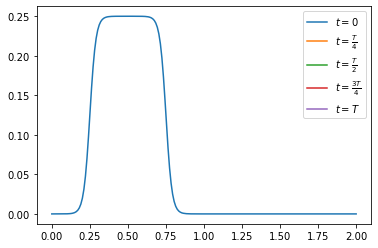

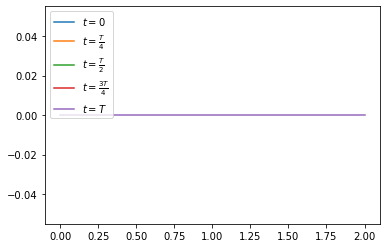

In [26]:
x  = np.linspace(0,L,m)

plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.legend()
plt.figure()
plt.plot(x,V[0],label=r"$t=0$")
plt.plot(x,V[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,V[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,V[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,V[n-1],label="$t=T$")
plt.legend()

## Terme intégrale

Text(0.5, 1.0, "Condition d'entrée")

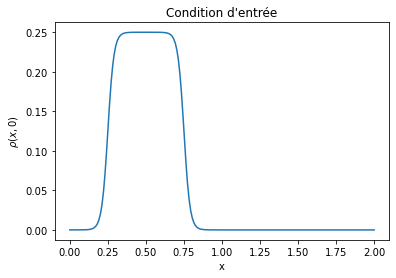

In [148]:
L = 2
T = 0.5
n = 200
m = 200
x  = np.linspace(0,L,m)
rho_0 = 0.25*(1/(1+np.exp(-50*(x-0.25))) - 1/(1+np.exp(-50*(x-0.75))))

plt.figure()
plt.plot(x,rho_0)
plt.xlabel('x')
plt.ylabel(r'$\rho(x,0)$')
plt.title("Condition d'entrée")

In [179]:
def discretisation_Goatin(rho,x,L,T,eta,w,c):
    m = len(rho[0]) - 1
    n = len(rho[0]) - 1
    dx = L/(m+1)
    dt = T/(n+1)
    vmax = 0.1
    # k sera le nombre de pas utilisés pour le calcul de l'intégrale
    k = int((eta*(m+1))//L) - 1
    for j in range(n):
        for i in range(1,m-k-1):
            
            # f[n][i+1]
            fnavant = vmax * rho[j][i+1] * (1 - sum([rho[j][i+1+h] * w(x[h]) * dx for h in range(1,k+1)]))
            # f[n][i-1]
            fnarriere = vmax * rho[j][i-1] * (1 - sum([rho[j][i-1+h] * w(x[h]) *dx for h in range(1,k+1)]))
            rho[j+1][i] = rho[j][i] - dt/(2*dx) * rho[j][i+1]*(fnavant - fnarriere) + 1/2 * (rho[j][i-1] - 2 * rho[j][i] + rho[j][i+1])
        for i in range(m-k-1,m):
            rho_tronque = rho[j][i:]
            # f[n][i+1]
            fnavant = vmax * rho[j][i+1] * (1 - sum([rho_tronque[h+1] * w(x[h]) for h in range(1,len(rho_tronque)-1)]))
            # f[n][i-1]
            fnarriere = vmax * rho[j][i-1] * (1 - sum([rho_tronque[h-1] * w(x[h]) for h in range(1,len(rho_tronque))]))
            rho[j+1][i] = rho[j][i] - dt/(2*dx) * rho[j][i+1]*(fnavant - fnarriere) + 1/2* (rho[j][i-1] - 2 * rho[j][i] + rho[j][i+1])
    return rho

In [186]:
L = 2
T = 2
n = 200
m = 200
x  = np.linspace(0,L,m)
rho_0 = 0.5* (1/(1+np.exp(-50*(x-0.75))) - 1/(1+np.exp(-50*(x-1.25))))
rho = [[rho_0[j] for j in range(m)] for i in range(n)]
EX0 = sum([x[i] * rho_0[i]*L/m for i in range(len(x))])
VarX0 = sum([(x[i]-EX0)**2 * rho_0[i] * L/m for i in range(len(x))])
lda = 0.005 * np.sqrt(VarX0)
#assert  max(np.abs(1-2*rho_0)) <= (L*n)/(2*T*m)
#c = (L*n)/(2*T*m)
w = lambda x: np.exp(-eta/lda) + 1/lda * np.exp(-x/lda)
rho = discretisation_Goatin(rho,x,L,T,eta,w,c)
eta = 0.1


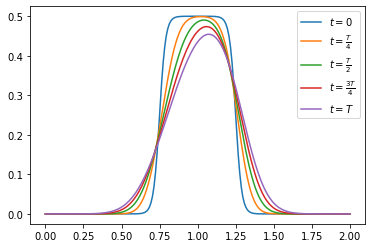

In [187]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.legend()

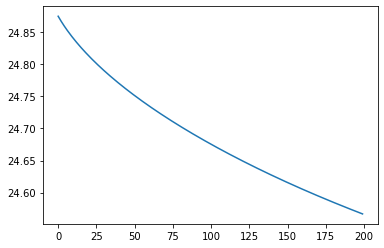

In [188]:
masse = [sum(rho[j]) for j in range (n)]
plt.plot(masse)

In [153]:
L = 2
T = 1
n = 200
m = 200
x  = np.linspace(0,L,m)
rho_0 = 0.25*np.exp(-((x-1)/0.15)**2)
rho = [[rho_0[j] for j in range(m)] for i in range(n)]
EX0 = sum([x[i] * rho_0[i]*L/m for i in range(len(x))])
VarX0 = sum([(x[i]-EX0)**2 * rho_0[i] * L/m for i in range(len(x))])
lda = 0.1 * np.sqrt(VarX0)
assert  max(np.abs(1-2*rho_0)) <= (L*n)/(2*T*m)
c = (L*n)/(2*T*m)
w = lambda x: np.exp(-eta/lda) + 1/lda * np.exp(-x/lda)
rho = discretisation_Goatin(rho,x,L,T,eta,w,c)
eta = 0.1


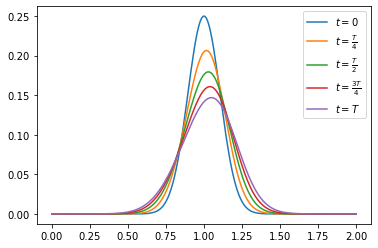

In [154]:
plt.figure()
plt.plot(x,rho[0],label=r"$t=0$")
plt.plot(x,rho[n//4-1],label=r"$t=\frac{T}{4}$")
plt.plot(x,rho[n//2-1],label=r"$t=\frac{T}{2}$")
plt.plot(x,rho[3*n//4-1],label=r"$t=\frac{3T}{4}$")
plt.plot(x,rho[n-1],label="$t=T$")
plt.legend()

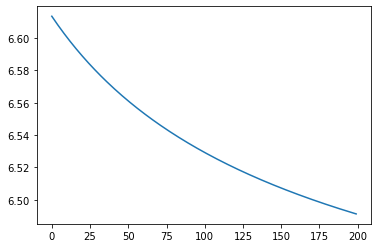

In [155]:
masse = [sum(rho[j]) for j in range (n)]
plt.plot(masse)